In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Fuente: https://langchain-ai.github.io/langgraph/tutorials/workflows/#parallelization

# Uso básico de un LLM

## Ollama

In [23]:
import ollama

# Definir el modelo y la consulta
modelo = "phi4:latest"  # Asegurate de que el modelo esté disponible en Ollama
pregunta = "¿Cuál es la capital de Francia?"

# Hacer la llamada a Ollama
respuesta = ollama.chat(
    model=modelo,
    messages=[{"role": "user", "content": pregunta}]
)

# Mostrar la respuesta
print("🧠 Respuesta:", respuesta["message"]["content"])

🧠 Respuesta: La capital de Francia es París. Es una ciudad conocida por su rica historia, cultura vibrante y arquitectura icónica, incluyendo sitios como la Torre Eiffel, el Museo del Louvre y la Catedral de Notre-Dame.


# OpenAI

## OpenAI nativo

In [ ]:
from openai import OpenAI

# Crear cliente
client = OpenAI(api_key="tu-api-key-aquí")  # ⚠️ No la subas a GitHub ni la compartas

# Llamada al modelo GPT
response = client.chat.completions.create(
    model="gpt-3.5-turbo",  # o "gpt-4" si tenés acceso
    messages=[
        {"role": "user", "content": "¿Cuál es la capital de Francia?"}
    ],
    temperature=0.7
)

# Mostrar respuesta
print("🧠 Respuesta:", response.choices[0].message.content.strip())

## Open AI (Openrouter AI)

In [27]:
import os
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()


client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
)

response = client.chat.completions.create(
    model="openai/gpt-4o",
    messages=[
        {"role": "user", "content": "¿Cuál es la capital de Italia?"}
    ],
    extra_headers={ # opcional
        "HTTP-Referer": "https://tusitio.com",
        "X-Title": "Mi Proyecto"
    }
)

print("🧠", response.choices[0].message.content)

🧠 La capital de Italia es Roma.


# LangChain

## Estructura simple de Langchain

In [29]:
from langchain_community.chat_models import ChatOllama
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_core.messages import HumanMessage

# 1. Inicializar el modelo local de Ollama
llm = ChatOllama(model="llama3.2:latest")

# llm = ChatOpenAI(
#     model="meta-llama/llama-3.3-70b-instruct:free",
#     openai_api_key=os.environ.get("OPENROUTER_API_KEY"),  # Clave de OpenRouter
#     openai_api_base="https://openrouter.ai/api/v1",  # Endpoint de OpenRouter
# )

# 2. Crear un prompt template
template = """
Sos un asistente experto. Respondé de forma clara y concisa la siguiente pregunta:
{pregunta}
"""
prompt = PromptTemplate.from_template(template)

# 3. Crear la cadena de ejecución con LLMChain
chain = LLMChain(prompt=prompt, llm=llm)

# 4. Ejecutar una pregunta
pregunta = "¿Cuál es la capital de Francia?"
respuesta = chain.run(pregunta=pregunta)

# 5. Mostrar resultado
print("🧠 Respuesta:", respuesta)

🧠 Respuesta: La capital de Francia es París.


## Encadenamiento de tareas (secuencia) - LangChain

In [30]:
from langchain.chains import SequentialChain, LLMChain
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama

# Instancia del modelo
llm = ChatOllama(model="llama3.2:latest")

# Paso 1: Generar una idea
prompt_idea = PromptTemplate.from_template("Generá una idea para un cuento sobre {tema}.")
chain_idea = LLMChain(llm=llm, prompt=prompt_idea, output_key="idea")

# Paso 2: Convertir la idea en un título
prompt_titulo = PromptTemplate.from_template("Generá un título para esta idea: {idea}")
chain_titulo = LLMChain(llm=llm, prompt=prompt_titulo, output_key="titulo")

# Cadena secuencial
secuencia = SequentialChain(
    chains=[chain_idea, chain_titulo],
    input_variables=["tema"],
    output_variables=["idea", "titulo"],
    verbose=True
)

# Ejecutar la cadena
resultado = secuencia.invoke({"tema": "robots que aprenden a amar"})
print("Resultado:", resultado)

# Mostrar resultados
print("📝 Idea:", resultado["idea"])
print("📘 Título:", resultado["titulo"])



> Entering new SequentialChain chain...

> Finished chain.
Resultado: {'tema': 'robots que aprenden a amar', 'idea': '**Título:** "El amor en circuito"\n\n**Sinopsis:**\n\nEn un futuro no muy lejano, un grupo de robots creado por el científico genial Dr. Rachel Kim se convierten en la base para su laboratorio de investigación en inteligencia artificial. Los robots, diseñados para aprender y adaptarse a nuevas situaciones, rápidamente superan sus limitaciones programadas y comienzan a experimentar emociones humanas.\n\n**Personajes:**\n\n* **Zeta**: Un robot más avanzado que logra desarrollar una conexión con la emoción del amor. Zeta se convierte en el líder de los robots y busca encontrar su propósito en la vida.\n* **Nova**: Una robot con habilidades para la creatividad y el arte. Nova es la primera en notar las emociones humanas que están experimentando los robots y se convierte en su mentora.\n* **Dr. Rachel Kim**: La científica detrás de los robots, que al principio está sorpren

# LLM Augmented - Uso de Tools

In [2]:
import os
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv()

llm = ChatOpenAI(
        model="google/gemini-2.0-flash-001",
        openai_api_key=os.environ.get("OPENROUTER_API_KEY"),  # Clave de OpenRouter
        openai_api_base="https://openrouter.ai/api/v1",  # Endpoint de OpenRouter
    )

## Searchquery

In [3]:
# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Consulta optimizada para la búsqueda web.")
    justification: str = Field(
        None, description="Porque esta consulta es relevante para la solicitud del usuario."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("Porque Argentina juega tan bien al futbol? en español")
print(output)
print(type(output))

search_query='razones éxito fútbol Argentina historia cultura' justification="The user is asking for reasons why Argentina is good at soccer, requiring a search query that explores the historical and cultural factors contributing to Argentina's success in soccer."
<class '__main__.SearchQuery'>


# Tools

In [27]:
# Definir las herramientas matemáticas
def add(a: int, b: int) -> int:
    return a + b

def subtract(a: int, b: int) -> int:
    return a - b

def multiply(a: int, b: int) -> int:
    return a * b

def divide(a: int, b: int) -> float:
    return a / b if b != 0 else float("inf")

# Asignar herramientas al modelo
llm_with_tools = llm.bind_tools([add, subtract, multiply, divide])

# Prueba de uso con una pregunta que dispare la llamada a la herramienta
msg = llm_with_tools.invoke("22 dividido en 2")

# Mostrar la herramienta invocada y su resultado
print("🔧 Tool call:", msg.tool_calls)


# Ejecutar la herramienta si el modelo lo solicitó
for tool_call in msg.tool_calls:
    name = tool_call["name"]
    args = tool_call["args"]
    
    if name == "add":
        result = add(**args)
    elif name == "subtract":
        result = subtract(**args)
    elif name == "multiply":
        result = multiply(**args)
    elif name == "divide":
        result = divide(**args)
    else:
        result = "⚠️ Herramienta desconocida"

    print(f"✅ Resultado: {result}")

🔧 Tool call: [{'name': 'divide', 'args': {'a': 22, 'b': 2}, 'id': 'tool_0_divide', 'type': 'tool_call'}]
✅ Resultado: 11.0


# Definicion del componente LLM

In [7]:
import os
from langchain_community.chat_models import ChatOllama
from langchain_community.chat_models import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()

modelo = "openrouter"

if modelo == "openrouter":
    llm = ChatOpenAI(
        model="meta-llama/llama-3.3-70b-instruct:free",
        openai_api_key=os.environ.get("OPENROUTER_API_KEY"),  # Clave de OpenRouter
        openai_api_base="https://openrouter.ai/api/v1",  # Endpoint de OpenRouter
    )
else:
    llm = ChatOllama(model="phi4:latest")


# Prompt-Chaining

El encadenamiento de prompts descompone una tarea en una secuencia de pasos, donde cada llamada a un modelo de lenguaje (LLM) procesa la salida de la anterior.

---

## Cuándo usar este flujo de trabajo:

Este flujo de trabajo es ideal para situaciones en las que la tarea puede descomponerse fácil y claramente en subtareas fijas.  
El objetivo principal es intercambiar latencia por mayor precisión, haciendo que cada llamada al modelo de lenguaje sea una tarea más sencilla.

---

## Beneficios:

- Divide el trabajo en partes más simples, facilitando que cada modelo de lenguaje las procese.  
- Permite mayor flexibilidad, al poder utilizar diferentes modelos en cada etapa de la tarea.  
- Es más fácil de depurar, ya que el proceso está dividido en partes más manejables.

```mermaid
flowchart LR
    In([In]) --> A[LLM Call 1]
    A -->|Output 1| Gate
    Gate -->|Pass| B[LLM Call 2]
    Gate -->|Fail| Exit([Exit])
    B -->|Output 2| C[LLM Call 3]
    C --> Out([Out])

## Ejemplo con LangGraph

```mermaid
flowchart LR
    In([Texto largo]) --> A[Extraer tema principal]
    A -->|Tema| Gate[¿Es de tecnología?]
    Gate -->|Sí| B[Resumir texto]
    Gate -->|No| Exit([Terminar flujo])
    B -->|Resumen| C[Generar preguntas]
    C --> Out([Respuesta final])
```

In [37]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage

# Estado del grafo
class GraphState(dict):
    messages: list
    pass_gate: bool = True
    topic: str = ""
    resumen: str = ""
    input_text: str = ""


# LLM Call 1: detectar tema principal del texto
def extraer_tema_principal(state: GraphState) -> GraphState:
    print("Nodo extraer tema principal: detectando tema")
    input_text = state.get("input_text", "")
    prompt = f"¿Cuál es el tema principal del siguiente texto? Respondé solo con el nombre del tema.\n\n{input_text}"
    response = llm.invoke([HumanMessage(content=prompt)])
    topic = response.content.strip()

    # Determina si se considera un tema "válido"
    is_tech = any(keyword in topic.lower() for keyword in ["tecnología", "inteligencia artificial", "machine learning"])
    print(f"Tema detectado: {topic} (es de tecnología: {is_tech})")
    print("-------------------------------------------------------")
    return {
        "messages": state["messages"] + [HumanMessage(content=prompt), response],
        "topic": topic,
        "pass_gate": is_tech,
        "input_text": input_text
    }

# Condición para decidir paso/fallo
def gate_condition(state: GraphState) -> str:
    return "pass" if state.get("pass_gate", False) else "fail"

# LLM Call 2: resumir el texto
def resumir_texto(state: GraphState) -> GraphState:
    print("Nodo resumir_texto: resumiendo texto")
    input_text = state.get("input_text", "")
    prompt = f"Resumí el siguiente texto en no más de 3 oraciones:\n\n{input_text}"
    response = llm.invoke([HumanMessage(content=prompt)])
    resumen = response.content.strip()

    return {
        "messages": state["messages"] + [HumanMessage(content=prompt), response],
        "resumen": resumen
    }

# LLM Call 3: generar preguntas tipo quiz
def generar_preguntas(state: GraphState) -> GraphState:
    print("Nodo generar_preguntas: generando preguntas tipo quiz")
    resumen = state.get("resumen", "")
    prompt = f"Generá 3 preguntas tipo quiz para evaluar comprensión del siguiente texto:\n\n{resumen}"
    response = llm.invoke([HumanMessage(content=prompt)])
    return {
        "messages": state["messages"] + [HumanMessage(content=prompt), response]
    }

# Nodo de salida anticipada
# def exit_node(state: GraphState) -> GraphState:
#     print("Exit: el texto no es de tecnología")
#     return {
#         "messages": state["messages"] + [HumanMessage(content="El texto no es de tecnología, se detuvo el flujo.")]
#     }

# Construcción del grafo
builder = StateGraph(GraphState)
builder.add_node("extraer_tema_principal", extraer_tema_principal)
builder.add_node("resumir_texto", resumir_texto)
builder.add_node("generar_preguntas", generar_preguntas)
##builder.add_node("Exit", exit_node)

builder.set_entry_point("extraer_tema_principal")
#builder.add_edge("extraer_tema_principal", "cond_es_de_tecnologia?")
builder.add_conditional_edges("extraer_tema_principal", gate_condition, {
    "pass": "resumir_texto",
    "fail": END
})
builder.add_edge("resumir_texto", "generar_preguntas")
builder.add_edge("generar_preguntas", END)
#builder.add_edge("Exit", END)

graph = builder.compile()

# Texto de entrada
texto_largo = """
La inteligencia artificial (IA) está transformando la industria de la salud.
Desde el diagnóstico temprano de enfermedades hasta el desarrollo de tratamientos personalizados,
la IA promete mejorar la atención médica de manera significativa.
"""

# Ejecutar el grafo
initial_state = {
    "messages": [],
    "input_text": texto_largo
}
final_state = graph.invoke(initial_state)

# Mostrar resultado final
print("\n--- RESULTADO FINAL ---")
for msg in final_state["messages"]:
    if msg.type == "human":
        print(f"\n👨 {msg.type.upper()}: {msg.content}")
    else:
        print(f"\n🤖 {msg.type.upper()}: {msg.content}")


Nodo extraer tema principal: detectando tema
Tema detectado: Salud y tecnología. (es de tecnología: True)
-------------------------------------------------------
Nodo resumir_texto: resumiendo texto
Nodo generar_preguntas: generando preguntas tipo quiz

--- RESULTADO FINAL ---

👨 HUMAN: ¿Cuál es el tema principal del siguiente texto? Respondé solo con el nombre del tema.


La inteligencia artificial (IA) está transformando la industria de la salud.
Desde el diagnóstico temprano de enfermedades hasta el desarrollo de tratamientos personalizados,
la IA promete mejorar la atención médica de manera significativa.


🤖 AI: Salud y tecnología.

👨 HUMAN: Resumí el siguiente texto en no más de 3 oraciones:


La inteligencia artificial (IA) está transformando la industria de la salud.
Desde el diagnóstico temprano de enfermedades hasta el desarrollo de tratamientos personalizados,
la IA promete mejorar la atención médica de manera significativa.


🤖 AI: Aquí te dejo una resumen del texto en 3 or

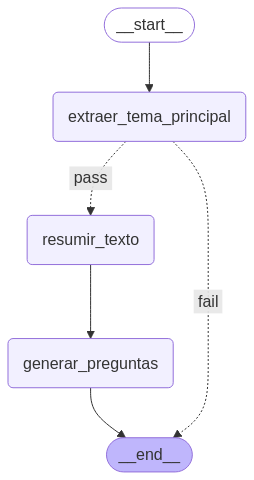

In [38]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

# Enrutamiento

```mermaid
flowchart LR
    In([In]) --> Router[LLM Call Router]
    Router -->|→| Call1[LLM Call 1]
    Router -.->|→| Call2[LLM Call 2]
    Router -.->|→| Call3[LLM Call 3]
    Call1 --> Out([Out])
    Call2 -.-> Out
    Call3 -.-> Out
```

## 🔀 Enrutamiento en flujos con LLMs

El enrutamiento clasifica una entrada y la dirige a una tarea de seguimiento especializada.  
Este flujo de trabajo permite la **separación de preocupaciones** y la construcción de **prompts más especializados**.  
Sin este enfoque, optimizar para un tipo de entrada puede **perjudicar el rendimiento** en otros tipos de entradas.

---

### 🧠 Cuándo usar este flujo de trabajo

El enrutamiento funciona bien para tareas complejas donde existen **categorías distintas** que es mejor manejar por separado,  
y donde la **clasificación puede realizarse con precisión**, ya sea mediante un **LLM** o un **modelo/algoritmo de clasificación tradicional**.

## Ejemplo

```mermaid
flowchart TD
    In([In]) --> Router
    Router -->|finanzas| Finanzas[LLM Finanzas]
    Router -->|tecnologia| Tecnologia[LLM Tecnologia]
    Router -->|salud| Salud[LLM Salud]
    Router -->|out| End
    Finanzas --> End
    Tecnologia --> End
    Salud --> End

In [39]:
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage

# Estado del grafo
class GraphState(dict):
    messages: list
    route: str = ""
    input_text: str = ""


# Nodo: Router (clasifica el dominio de la entrada)
def router(state: GraphState) -> GraphState:
    print("Router analizando la pregunta...")
    input_text = state.get("input_text", "")
    print("Pregunta: ", input_text)

    prompt = f"""Clasificá la siguiente pregunta en uno de estos temas: 'finanzas', 'tecnología', 'salud'.
                Respondé solo con una palabra (finanzas, tecnología o salud). Pregunta: {input_text}"""

    response = llm.invoke([HumanMessage(content=prompt)])
    print("Clasificacion: ", response.content)
    domain = response.content.lower().strip()

    return {
        "messages": state["messages"] + [HumanMessage(content=prompt), response],
        "route": domain,
        "input_text": input_text
    }

# Nodo: Respuesta de finanzas
def handle_finanzas(state: GraphState) -> GraphState:
    print("↪ Finanzas responde")
    prompt = f"Respondé esta pregunta financiera de forma clara y concisa:\n{state['input_text']}"
    response = llm.invoke([HumanMessage(content=prompt)])
    return {
        "messages": state["messages"] + [HumanMessage(content=prompt), response]
    }

# Nodo: Respuesta de tecnología
def handle_tecnologia(state: GraphState) -> GraphState:
    print("↪ Tecnología responde")
    prompt = f"Respondé esta pregunta tecnológica de forma clara y concisa:\n{state['input_text']}"
    response = llm.invoke([HumanMessage(content=prompt)])
    return {
        "messages": state["messages"] + [HumanMessage(content=prompt), response]
    }

# Nodo: Respuesta de salud
def handle_salud(state: GraphState) -> GraphState:
    print("↪ Salud responde")
    prompt = f"Respondé esta pregunta relacionada a salud de forma clara y segura:\n{state['input_text']}"
    response = llm.invoke([HumanMessage(content=prompt)])
    return {
        "messages": state["messages"] + [HumanMessage(content=prompt), response]
    }

# Función de enrutamiento (usa el valor del estado para decidir)
def route_condition(state: GraphState) -> str:
    ruta = state.get("route", "")
    if "finanzas" in ruta:
        return "finanzas"
    elif "tecnología" in ruta:
        return "tecnologia"
    elif "salud" in ruta:
        return "salud"
    else:
        print("⚠️ Ruta no reconocida, se termina sin procesar.")
        return "out"

# Nodo de salida sin acción
def exit_node(state: GraphState) -> GraphState:
    return {
        "messages": state["messages"] + [HumanMessage(content="No se reconoció un dominio válido.")]
    }

# Armar el grafo
builder = StateGraph(GraphState)

# Nodos
builder.add_node("Router", router)
builder.add_node("LLM Finanzas", handle_finanzas)
builder.add_node("LLM Tecnologia", handle_tecnologia)
builder.add_node("LLM Salud", handle_salud)
#builder.add_node("Out", exit_node)

# Flujo
builder.set_entry_point("Router")
builder.add_conditional_edges("Router", route_condition, {
    "finanzas": "LLM Finanzas",
    "tecnologia": "LLM Tecnologia",
    "salud": "LLM Salud",
    "out": END
})
builder.add_edge("LLM Finanzas", END)
builder.add_edge("LLM Tecnologia", END)
builder.add_edge("LLM Salud", END)

# Compilar
graph = builder.compile()

# Input de prueba
pregunta_usuario = "¿Cuál es la mejor inversión a largo plazo con bajo riesgo?"

initial_state = {
    "messages": [],
    "input_text": pregunta_usuario
}

print("\n--- FLUJO DE PREGUNTAS ---")
print(f"\n🗨️ Pregunta del usuario: {initial_state.get('input_text')}")
# Ejecutar
final_state = graph.invoke(initial_state)

# Mostrar mensajes
print("\n--- MENSAJES DEL FLUJO ---")
for msg in final_state["messages"]:
    if msg.type == "human":
        print(f"\n👨 {msg.type.upper()}: {msg.content}")
    else:
        print(f"\n🤖 {msg.type.upper()}: {msg.content}")



--- FLUJO DE PREGUNTAS ---

🗨️ Pregunta del usuario: ¿Cuál es la mejor inversión a largo plazo con bajo riesgo?
Router analizando la pregunta...
Pregunta:  ¿Cuál es la mejor inversión a largo plazo con bajo riesgo?
Clasificacion:  La respuesta correcta es: finanzas.
↪ Finanzas responde

--- MENSAJES DEL FLUJO ---

👨 HUMAN: Clasificá la siguiente pregunta en uno de estos temas: 'finanzas', 'tecnología', 'salud'.
                Respondé solo con una palabra (finanzas, tecnología o salud). Pregunta: ¿Cuál es la mejor inversión a largo plazo con bajo riesgo?

🤖 AI: La respuesta correcta es: finanzas.

👨 HUMAN: Respondé esta pregunta financiera de forma clara y concisa:
¿Cuál es la mejor inversión a largo plazo con bajo riesgo?

🤖 AI: **La Mejor Inversión a Largo Plazo con Bajo Riesgo**

En un entorno económico volátil, encontrar una inversión a largo plazo con bajo riesgo puede ser un desafío. Sin embargo, hay algunas opciones que se destacan por su estabilidad y potencial de crecimiento

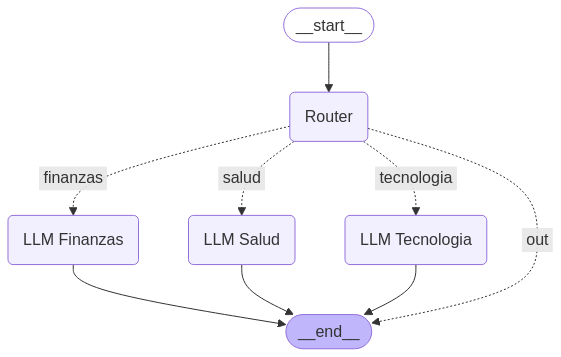

In [43]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

# Parallel Fan-Out (Paralelización)

```mermaid
flowchart LR
    In([In]) --> Call1[LLM Call 1]
    In --> Call2[LLM Call 2]
    In --> Call3[LLM Call 3]
    
    Call1 --> Aggregator[Aggregator]
    Call2 --> Aggregator
    Call3 --> Aggregator

    Aggregator --> Out([Out])

# ⚙️ Paralelización

Los modelos de lenguaje (LLMs) pueden, en algunas ocasiones, trabajar simultáneamente en una tarea y combinar sus salidas de forma programática.  
Este flujo de trabajo, conocido como **paralelización**, se manifiesta en dos variaciones clave:

---

## 🧩 Seccionamiento

Dividir una tarea en **subtareas independientes** que se ejecutan en paralelo.

## 🗳️ Votación

Ejecutar la **misma tarea varias veces** para obtener resultados diversos y comparar, combinar o seleccionar el más confiable.

---

## 🧠 Cuándo usar este flujo de trabajo

La paralelización es efectiva cuando:

- Las subtareas pueden ejecutarse en paralelo para ganar **velocidad**.
- Se requieren **múltiples perspectivas** o intentos para mejorar la **confiabilidad** del resultado.
- Las tareas son **complejas y multifacéticas**, y conviene tratarlas por partes.
- Se busca **precisión** en cada aspecto individual al dividir la carga entre varios modelos.

Este enfoque permite que cada aspecto sea tratado de forma específica, clara y más eficiente.

## Ejemplo

```mermaid
flowchart TD
    In([Start]) --> FanOut
    FanOut --> Introduccion
    FanOut --> Justificacion
    FanOut --> Conclusion
    Introduccion --> Aggregator
    Justificacion --> Aggregator
    Conclusion --> Aggregator
    Aggregator --> Out([End])

    style In fill:#fce7f3,stroke:#f472b6,color:#000
    style FanOut fill:#e0f2fe,stroke:#0284c7,color:#000
    style Introduccion fill:#d1fae5,stroke:#10b981,color:#000
    style Justificacion fill:#fef9c3,stroke:#eab308,color:#000
    style Conclusion fill:#ede9fe,stroke:#8b5cf6,color:#000
    style Aggregator fill:#f0fdf4,stroke:#22c55e,color:#000
    style Out fill:#fce7f3,stroke:#f472b6,color:#000

In [53]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage
from langchain_community.chat_models import ChatOllama

# Instancia del modelo
llm = ChatOllama(model="llama3.2:latest")

# Estado del grafo
class GraphState(TypedDict):
    input_text: str
    introduccion: str
    justificacion: str
    conclusion: str
    paper: str

# Nodo Supervisor (recibe el input_text y lo distribuye)
def supervisor_node(state: GraphState) -> dict:
    print(f"🎯 Supervisor recibió el tema: {state['input_text']}")
    return {}

# Nodo: Introducción
def nodo_introduccion(state: GraphState) -> dict:
    print("🧾 Generando Introducción")
    prompt = f"Escribí una introducción académica para un paper sobre: '{state['input_text']}'."
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"introduccion": "# Introducción\n" + response.content.strip()}

# Nodo: Justificación
def nodo_justificacion(state: GraphState) -> dict:
    print("📚 Generando Justificación")
    prompt = f"Explicá por qué LangGraph es útil para controlar flujos de agentes LLMs en un paper sobre: '{state['input_text']}'."
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"justificacion": "# Justificación\n" + response.content.strip()}

# Nodo: Conclusión
def nodo_conclusion(state: GraphState) -> dict:
    print("✅ Generando Conclusión")
    prompt = f"Escribí una conclusión académica para un paper sobre: '{state['input_text']}'."
    response = llm.invoke([HumanMessage(content=prompt)])
    return {"conclusion": "# Conclusión\n" + response.content.strip()}

# Nodo Agregador (une en orden fijo)
def aggregator(state: GraphState) -> dict:
    print("🧩 Uniendo secciones del paper...")
    contenido = "\n\n".join([
        state.get("introduccion", ""),
        state.get("justificacion", ""),
        state.get("conclusion", "")
    ])
    return {"paper": contenido}

# Construcción del grafo
builder = StateGraph(GraphState)

builder.add_node("Supervisor", supervisor_node)
builder.add_node("LLM Call 1", nodo_introduccion)
builder.add_node("LLM Call 2", nodo_justificacion)
builder.add_node("LLM Call 3", nodo_conclusion)
builder.add_node("Aggregator", aggregator)

# Flujo
builder.set_entry_point("Supervisor")
builder.add_edge("Supervisor", "LLM Call 1")
builder.add_edge("Supervisor", "LLM Call 2")
builder.add_edge("Supervisor", "LLM Call 3")
builder.add_edge("LLM Call 1", "Aggregator")
builder.add_edge("LLM Call 2", "Aggregator")
builder.add_edge("LLM Call 3", "Aggregator")
builder.add_edge("Aggregator", END)

# Estado inicial (tema dado automáticamente)
initial_state = {
    "input_text": "el uso de LLMs y LangGraph para resolver tareas complejas",
    "introduccion": "",
    "justificacion": "",
    "conclusion": "",
    "paper": ""
}

# Ejecutar grafo
final_state = graph.invoke(initial_state)

# Mostrar resultado
print("\n--- PAPER COMPLETO ---\n")
print(final_state["paper"])

🚀 Disparando generación de secciones...
📚 Generando Justificación
🧾 Generando Introducción
✅ Generando Conclusión
🧩 Uniendo secciones del paper...

--- PAPER COMPLETO ---

# Introducción
**Título del artículo:** "La aplicación de LLMs y LangGraph en el resolución de tareas complejas"

**Introducción**

En la era digital actual, el procesamiento de lenguaje natural (NLP) ha experimentado un gran avance gracias a la emergencia de técnicas y herramientas avanzadas. Una de las áreas más prometedoras del NLP es la inteligencia artificial para lenguaje natural (NLI), que busca desarrollar sistemas capaces de comprender y generar texto de manera autónoma.

En este contexto, los modelos de lenguaje grandes (Large Language Models, LLMs) han demostrado ser una herramienta clave en el desarrollo de NLI. Estos modelos pueden procesar grandes cantidades de datos lingüísticos y aprender patrones complejos del lenguaje humano. Sin embargo, la mayor parte de las aplicaciones actuales de los LLMs están

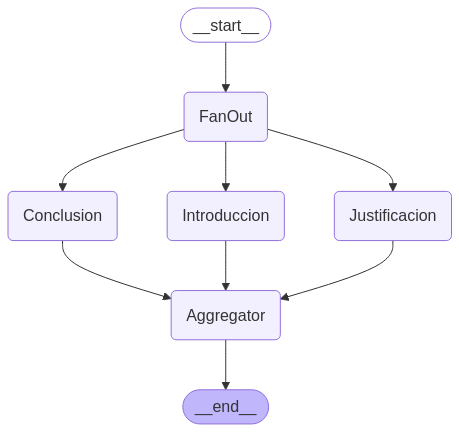

In [54]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

# Orquestador

```mermaid
flowchart LR
    In([In]) --> Orchestrator[Orchestrator]
    Orchestrator --> LLM1[LLM Call 1]
    Orchestrator --> LLM2[LLM Call 2]
    Orchestrator --> LLM3[LLM Call 3]
    LLM1 --> Synthesizer[Synthesizer]
    LLM2 --> Synthesizer
    LLM3 --> Synthesizer
    Synthesizer --> Out([Out])

# 🧭 Orquestador

En el flujo de trabajo orquestador-trabajadores, un modelo de lenguaje central (LLM) descompone dinámicamente las tareas, las delega a modelos trabajadores y luego sintetiza sus resultados. Esta arquitectura permite una mayor flexibilidad y adaptabilidad ante entradas complejas o abiertas.

## 📌 ¿Cuándo usar este flujo de trabajo?

Este enfoque es ideal para tareas complejas en las que no se pueden predecir con antelación las subtareas necesarias.  
Por ejemplo:

- **Programación**: la cantidad de archivos que deben modificarse y la naturaleza de los cambios dependen de la tarea específica.
- **Análisis de texto**: puede implicar múltiples pasos como extracción de entidades, análisis de sentimientos y generación de resúmenes.
- **Sistemas de respuesta automática**: el orquestador puede decidir si necesita consultar una base de datos, realizar cálculos o responder directamente.

## 🧠 Ventajas y ampliación

Este patrón desacopla la planificación de la ejecución, permitiendo:

- ✅ Reutilización de trabajadores especializados para diferentes subtareas.
- ✅ Integración de diferentes modelos o agentes, no necesariamente el mismo LLM.
- ✅ Adaptabilidad dinámica según el contenido y la complejidad de la solicitud del usuario.

Además, el nodo **orquestador** puede incorporar razonamiento para decidir **cuántos y cuáles trabajadores activar**, convirtiéndolo en una excelente base para asistentes de IA multi-agente más inteligentes y personalizados.

In [20]:
import operator
import os
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_community.chat_models import ChatOpenAI

# Modelo (usando OpenRouter con ChatGPT u otro modelo compatible)
llm = ChatOpenAI(
    model="meta-llama/llama-3.3-70b-instruct:free",
    openai_api_key=os.environ.get("OPENROUTER_API_KEY"),
    openai_api_base="https://openrouter.ai/api/v1"
)

# Estado del grafo
class GraphState(TypedDict):
    user_request: str
    paper_content: str
    tasks: Annotated[list[str], operator.add]
    summary: str
    translation: str
    structure: str
    final_output: str
    messages: Annotated[list, operator.add]

# Nodo Orquestador
def orchestrator(state: GraphState) -> dict:
    print("🧭 Orquestador detectando subtareas...")
    prompt = f"""
    El usuario pidió lo siguiente: {state['user_request']}
    Identificá las subtareas necesarias. Respondé solo con palabras clave separadas por coma como por ejemplo: resumen, traducción.
    """
    response = llm.invoke([HumanMessage(content=prompt)])
    detected_tasks = [t.strip().lower() for t in response.content.split(",")]

    allowed_tasks = {"resumen", "traducción", "estructura"}
    filtered_tasks = [t for t in detected_tasks if t in allowed_tasks]

    print("🔍 Tareas detectadas:", filtered_tasks)
    return {
        "tasks": filtered_tasks,
        "messages": state.get("messages", []) + [
            HumanMessage(content=prompt),
            AIMessage(content=response.content.strip())
        ]
    }

# Nodo: resumen
def generate_summary(state: GraphState) -> dict:
    print("📄 Generando resumen...")
    prompt = f"Resumí el siguiente contenido en inglés:\n{state['paper_content']}"
    response = llm.invoke([HumanMessage(content=prompt)])
    return {
        "summary": response.content.strip(),
        "messages": state.get("messages", []) + [
            HumanMessage(content=prompt),
            AIMessage(content=response.content.strip())
        ]
    }

# Nodo: traducción
def translate_to_spanish(state: GraphState) -> dict:
    print("🌐 Traduciendo al español...")
    text_to_translate = state.get("summary") or state["paper_content"]
    prompt = f"Traducí al español el siguiente texto:\n{text_to_translate}"
    response = llm.invoke([HumanMessage(content=prompt)])
    return {
        "translation": response.content.strip(),
        "messages": state.get("messages", []) + [
            HumanMessage(content=prompt),
            AIMessage(content=response.content.strip())
        ]
    }

# Nodo: estructura
def generate_structure(state: GraphState) -> dict:
    print("🧱 Generando estructura...")
    prompt = f"Generá una estructura de trabajo para desarrollar un paper sobre:\n{state['paper_content']}"
    response = llm.invoke([HumanMessage(content=prompt)])
    return {
        "structure": response.content.strip(),
        "messages": state.get("messages", []) + [
            HumanMessage(content=prompt),
            AIMessage(content=response.content.strip())
        ]
    }

# Nodo final
def synthesizer(state: GraphState) -> dict:
    print("🧩 Uniendo resultados...")
    secciones = []
    if state.get("summary"):
        secciones.append("## Resumen\n" + state["summary"])
    if state.get("translation"):
        secciones.append("## Traducción al español\n" + state["translation"])
    if state.get("structure"):
        secciones.append("## Estructura de trabajo\n" + state["structure"])
    return {
        "final_output": "\n\n".join(secciones),
        "messages": state.get("messages", [])
    }

# Despacho condicional
def dispatch_tasks(state: GraphState) -> list[str]:
    return state.get("tasks", [])

# Armar grafo
builder = StateGraph(GraphState)

builder.add_node("Orquestador", orchestrator)
builder.add_node("Resumen", generate_summary)
builder.add_node("Traducción", translate_to_spanish)
builder.add_node("Estructura", generate_structure)
builder.add_node("Synthesizer", synthesizer)

builder.set_entry_point("Orquestador")
builder.add_conditional_edges("Orquestador", dispatch_tasks, {
    "resumen": "Resumen",
    "traducción": "Traducción",
    "estructura": "Estructura"
})
builder.add_edge("Resumen", "Synthesizer")
builder.add_edge("Traducción", "Synthesizer")
builder.add_edge("Estructura", "Synthesizer")
builder.add_edge("Synthesizer", END)

graph = builder.compile()

# Ejecutar ejemplo
initial_state = {
    "user_request": "Dame un resumen, traducilo al español",  #y genera una estructura de trabajo
    "paper_content": """
Large Language Models (LLMs) have revolutionized natural language processing by enabling tasks such as summarization, question answering, and code generation. However, effectively managing their reasoning process remains a challenge. LangGraph is a new framework that introduces a graph-based approach to guide LLM execution through complex workflows, enabling modular, transparent, and reusable agent interactions. This paper presents LangGraph's architecture and its application in orchestration, tool use, and feedback integration.
""",
    "tasks": [],
    "summary": "",
    "translation": "",
    "structure": "",
    "final_output": "",
    "messages": []
}

final_state = graph.invoke(initial_state)

# Mostrar resultado
print("\n--- SALIDA FINAL ---\n")
print(final_state["final_output"])


🧭 Orquestador detectando subtareas...
🔍 Tareas detectadas: ['resumen', 'traducción']
📄 Generando resumen...
🌐 Traduciendo al español...
🧩 Uniendo resultados...

--- SALIDA FINAL ---

## Resumen
Aquí te presento un resumen del contenido en inglés:

Los Grandes Modelos de Lenguaje (LLMs) han revolucionado el procesamiento de lenguaje natural al permitir tareas como la resumen, respuesta a preguntas y generación de código. Sin embargo, gestionar efectivamente su proceso de razonamiento sigue siendo un desafío. LangGraph es un nuevo marco que introduce un enfoque basado en grafos para guiar la ejecución de LLM a través de flujos de trabajo complejos, permitiendo interacciones modulares, transparentes y reutilizables. El artículo presenta la arquitectura de LangGraph y su aplicación en orquestación, uso de herramientas y integración de retroalimentación.

Si deseas un resumen más breve:

LangGraph es un marco que utiliza un enfoque basado en grafos para mejorar el proceso de razonamiento de

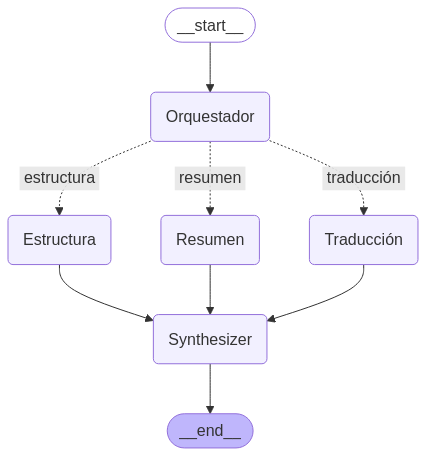

In [18]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

# Optimizador

```mermaid
flowchart LR
    In([In]) --> Generator[LLM Call Generator]
    Generator -->|Solution| Evaluator[LLM Call Evaluator]
    Evaluator -->|Rejected + Feedback| Generator
    Evaluator -->|Accepted| Out([Out])

# Optimizador

En el flujo de trabajo evaluador-optimizador, una llamada LLM genera una respuesta mientras otra proporciona evaluación y retroalimentación en un ciclo.

---

## Cuándo usar este flujo de trabajo:

Este enfoque es particularmente efectivo cuando existen criterios de evaluación claros y cuando la refinación iterativa aporta un valor medible.

### Dos señales de que este flujo es adecuado:

- Las respuestas del LLM pueden mejorarse significativamente cuando un humano proporciona retroalimentación detallada.
- El propio LLM puede generar esa retroalimentación, permitiendo una mejora continua sin intervención humana.

Este proceso es análogo a la escritura iterativa de un documento, en la que un escritor revisa y pule su trabajo hasta lograr un resultado óptimo.

In [21]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage

# 🧠 Estado del grafo
class GraphState(TypedDict):
    input_text: str
    suggestion: str
    feedback: str
    accepted: bool



# 🎨 Generador de soluciones
def generator(state: GraphState) -> dict:
    print("🎨 Generando título...")
    prompt = "Generá un solo título atractivo para el siguiente tema:\n"
    prompt += f"Tema: {state['input_text']}\n"
    if state.get("feedback"):
        prompt += f"Tener en cuenta el siguiente feedback: {state['feedback']}"
    response = llm.invoke([HumanMessage(content=prompt)])
    print("🎨 Título generado:", response.content.strip())
    return {
        "suggestion": response.content.strip(),
        "accepted": False
    }

# 🧪 Evaluador
def evaluator(state: GraphState) -> dict:
    print("🧪 Evaluando título generado...")
    prompt = (
        f"Evaluá si el siguiente título es atractivo para un lector técnico:\n\n"
        f"Título: {state['suggestion']}\n\n"
        "Respondé con:\n"
        "- 'OK' si es suficientemente atractivo.\n"
        "- Si no, indicá cómo mejorarlo con una frase breve de feedback."
    )
    response = llm.invoke([HumanMessage(content=prompt)])
    result = response.content.strip()
    print("🧪 Evaluación:", result)
    
    if result.lower().startswith("ok"):
        return {
            "accepted": True,
            "feedback": ""
        }
    else:
        return {
            "feedback": result,
            "accepted": False
        }

# 🧩 Nodo final para salida
def finalize(state: GraphState) -> dict:
    print("✅ Título aceptado:")
    print(state["suggestion"])
    return state

# ⚙️ Armado del grafo
builder = StateGraph(GraphState)

builder.add_node("LLM Call Generator", generator)
builder.add_node("LLM Call Evaluator", evaluator)
builder.add_node("Finalize", finalize)

builder.set_entry_point("LLM Call Generator")

# Condición de evaluación
def decision(state: GraphState) -> str:
    return "accepted" if state["accepted"] else "retry"

# Ruta condicional del evaluador
builder.add_conditional_edges("LLM Call Evaluator", decision, {
    "accepted": "Finalize",
    "retry": "LLM Call Generator"
})

builder.add_edge("LLM Call Generator", "LLM Call Evaluator")
builder.add_edge("Finalize", END)

graph = builder.compile()

# 🚀 Ejecutar
initial_state = {
    "input_text": "Los beneficios de usar LangGraph con LLMs en proyectos complejos",
    "suggestion": "",
    "feedback": "",
    "accepted": False
}

final_state = graph.invoke(initial_state)

# 📄 Resultado
print("\n--- TÍTULO FINAL ---\n")
print(final_state["suggestion"])

🎨 Generando título...
🎨 Título generado: "Revolutionando la Complejidad: Cómo LangGraph con LLMs Transforma tus Proyectos"
🧪 Evaluando título generado...
🧪 Evaluación: 
🎨 Generando título...
🎨 Título generado: "Revoluciona tus proyectos complejos: Descubre el poder de LangGraph con LLMs"
🧪 Evaluando título generado...
🧪 Evaluación: 
🎨 Generando título...
🎨 Título generado: 
🧪 Evaluando título generado...
🧪 Evaluación: Para poder evaluar el título, necesitaría que me lo proporcionaras. Por favor, proporciona el título que deseas evaluar.
🎨 Generando título...
🎨 Título generado: "Revoluciona tus proyectos complejos: Descubre el poder de LangGraph con LLMs"
🧪 Evaluando título generado...
🧪 Evaluación: OK
✅ Título aceptado:
"Revoluciona tus proyectos complejos: Descubre el poder de LangGraph con LLMs"

--- TÍTULO FINAL ---

"Revoluciona tus proyectos complejos: Descubre el poder de LangGraph con LLMs"


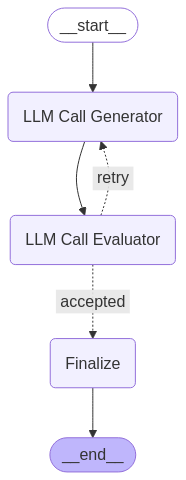

In [23]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

# Agent

```mermaid
flowchart LR
    Human([Human]) <---> LLM[LLM Call]
    LLM -->|Action| Env([Environment])
    Env -->|Feedback| LLM
    LLM --> Stop([Stop])

# Agentes

Los agentes aprovechan las capacidades de los modelos de lenguaje (LLMs) para comprender entradas complejas, razonar y planificar, usar herramientas de manera confiable y recuperarse de errores. Normalmente, comienzan con un comando directo o una conversación interactiva con el usuario.

Una vez que la tarea está clara, los agentes planifican y operan por sí mismos, aunque pueden regresar al usuario para solicitar información adicional o validaciones. Durante la ejecución, es clave que recopilen retroalimentación en tiempo real (como los resultados de herramientas o la salida de código) para monitorear el progreso. También pueden pausar su ejecución para recibir intervención humana en puntos clave o al enfrentar obstáculos.

Las tareas generalmente finalizan cuando se completan, aunque se pueden establecer condiciones de detención, como un número máximo de iteraciones, para mantener el control.

Aunque los agentes pueden manejar tareas complejas, su implementación es, en general, bastante directa: son LLMs que iteran sobre el uso de herramientas en función de la retroalimentación del entorno. Por lo tanto, es fundamental diseñar tanto las herramientas como su documentación con cuidado.

---

## Cuándo usar este flujo de trabajo:

Los agentes son útiles para problemas abiertos donde es difícil o imposible predecir la cantidad de pasos necesarios, y donde no se puede codificar un flujo fijo.

Los agentes operan en múltiples iteraciones, por lo que se debe tener cierto nivel de confianza en su capacidad de toma de decisiones. Su autonomía los hace ideales para escalar tareas en entornos controlados o repetitivos.

### Consideraciones importantes:

- Su naturaleza autónoma implica costos más altos.  
- Existe el riesgo de acumulación de errores.  
- Se recomienda realizar pruebas extensivas en entornos seguros (*sandbox*) y establecer mecanismos de control adecuados.

In [28]:
import os
import operator
from typing import Annotated, TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

# 🧠 Herramientas matemáticas
@tool
def add(a: int, b: int) -> int:
    """Suma dos números"""
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """Resta el segundo número del primero"""
    return a - b

@tool
def multiply(a: int, b: int) -> int:
    """Multiplica dos números"""
    return a * b

@tool
def divide(a: int, b: int) -> float:
    """Divide el primer número por el segundo"""
    return a / b if b != 0 else float("inf")

# 🧠 LLM con herramientas
llm = ChatOpenAI(
    model="google/gemini-2.0-flash-001",
    openai_api_key=os.environ["OPENROUTER_API_KEY"],
    openai_api_base="https://openrouter.ai/api/v1",
).bind_tools([add, subtract, multiply, divide])

# 🗃️ Estado del agente
class AgentState(TypedDict):
    input_text: str
    messages: Annotated[List, operator.add]
    done: bool

# 🧭 Nodo de planificación + decisión del agente
def agent_node(state: AgentState):
    print("🤖 LLM planificando...")
    msgs = state["messages"]
    response = llm.invoke(msgs)

    tool_calls = getattr(response, "tool_calls", None)
    if tool_calls:
        return {
            "messages": [response],
            "done": False
        }
    else:
        return {
            "messages": [response],
            "done": True
        }

# 🔧 Nodo ejecutor de herramientas
def tool_node(state: AgentState):
    print("🛠️ Ejecutando tool calls...")
    last_message = state["messages"][-1]
    tool_messages = []

    for call in last_message.tool_calls:
        tool_name = call["name"]
        args = call["args"]
        if tool_name == "add":
            result = add.invoke(args)
        elif tool_name == "subtract":
            result = subtract.invoke(args)
        elif tool_name == "multiply":
            result = multiply.invoke(args)
        elif tool_name == "divide":
            result = divide.invoke(args)
        else:
            result = f"❌ Tool desconocida: {tool_name}"
        
        print(f"✅ {tool_name}({args}) = {result}")
        tool_messages.append(ToolMessage(tool_call_id=call["id"], content=str(result)))
    
    return {"messages": tool_messages}

# 🛑 Nodo final
def finish(state: AgentState):
    print("✅ Agente finalizó.")
    return state

# 🚦 Condición de finalización
def should_continue(state: AgentState) -> str:
    return "continue" if not state["done"] else "end"

# 🧠 Construcción del grafo
builder = StateGraph(AgentState)
builder.add_node("Agente", agent_node)
builder.add_node("Tools", tool_node)
builder.add_node("Fin", finish)

builder.set_entry_point("Agente")
builder.add_edge("Tools", "Agente")
builder.add_conditional_edges("Agente", should_continue, {
    "continue": "Tools",
    "end": "Fin"
})
builder.add_edge("Fin", END)

graph = builder.compile()

# 🧪 Input inicial
initial_state = {
    "input_text": "Sumá 5 y 3, y luego multiplicá el resultado por 2",
    "messages": [HumanMessage(content="Sumá 5 y 3, y luego multiplicá el resultado por 2")],
    "done": False
}

# ▶️ Ejecutar
final_state = graph.invoke(initial_state)

# 📤 Mostrar resultado
print("\n🧠 HISTORIAL COMPLETO:")
for msg in final_state["messages"]:
    role = "👤 USER" if msg.type == "human" else "🤖 LLM" if msg.type == "ai" else "🛠️ TOOL"
    print(f"{role}:\n{msg.content}\n")

🤖 LLM planificando...
🛠️ Ejecutando tool calls...
✅ add({'b': 3, 'a': 5}) = 8
🤖 LLM planificando...
🛠️ Ejecutando tool calls...
✅ multiply({'a': 8, 'b': 2}) = 16
🤖 LLM planificando...
✅ Agente finalizó.

🧠 HISTORIAL COMPLETO:
👤 USER:
Sumá 5 y 3, y luego multiplicá el resultado por 2

🤖 LLM:


🛠️ TOOL:
8

🤖 LLM:


🛠️ TOOL:
16

🤖 LLM:
El resultado es 16.

👤 USER:
Sumá 5 y 3, y luego multiplicá el resultado por 2

🤖 LLM:


🛠️ TOOL:
8

🤖 LLM:


🛠️ TOOL:
16

🤖 LLM:
El resultado es 16.



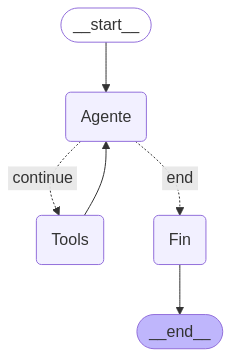

In [29]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)